# Context-based models

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set(font='IPAGothic')

from scipy.signal import find_peaks
from scipy import interpolate
from scipy.ndimage import shift

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import differential_evolution

from sklearn.metrics import mean_squared_error as mse

import itertools
from datetime import date, timedelta, datetime
import time

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'

comma_strip = lambda x: x.rstrip(",")

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

from bertopic import BERTopic
from dateutil.relativedelta import relativedelta

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dormant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2023-06-25 19:23:15.688595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 19:23:16.028860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-25 19:23:16.028899: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-25 19:23:16.109654: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-25 19:23:17.183955: W tensorflow/stream_executor/platform/de

## Helper functions

In [2]:
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != " " \
              and token.strip() not in punctuation
              and token.strip() not in ["«", "»", "“", "”"]]
    text = " ".join(tokens)
    return text

datify = lambda x: datetime.strptime(x, '%Y-%m-%d')
textify = lambda x: x.strftime('%Y-%m-%d')

def fill_nan(arr):
    A = np.array(arr)
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

def normal(length=100, mu=0, sigma=1, boost=1):
    con = 1 / np.sqrt(2*np.pi*sigma)
    arr = [con*np.exp(-(item-mu)**2/(2*(sigma**2))) for item in range(length)]
    arr = np.array(arr)
    arr = arr/arr.max()*boost
    return arr

def squish(arr):
    return arr/arr.max()

def sharpen(arr, prom=0.8, width=20, extra=1.2):
    x = list(arr)
    peaks_p, _ = find_peaks(x, prominence=(None, prom))
    peaks_n, _ = find_peaks([-item for item in x], prominence=(None, prom))
    vals_p = [x[peak] for peak in peaks_p]
    vals_n = [x[peak] for peak in peaks_n]
    
    for idx, peak in enumerate(peaks_p):
        gaussian = normal(len(x), peak, width, vals_p[idx]*extra)
        x += gaussian

    for idx, peak in enumerate(peaks_n):
        gaussian = normal(len(x), peak, width, vals_n[idx]*extra)
        x -= gaussian
    
    x = np.array(x)
    return x, peaks_p, vals_p, peaks_n, vals_n

def normalize_pandas(a):
    ratio = 2 / (a.max() - a.min()) 
    shift = (a.max() + a.min()) / 2 
    return (a - shift) * ratio

## Preparing transactions

In [3]:
data = pd.read_csv('../DATA-MINING/OTHER-DATA/TRANS/trans_big.csv')
data['TRANS_DATE'] = pd.to_datetime(data.date)
vallab = ['food', 'outfit', 'dwelling', 'health',
          'beauty', 'remote', 'travel', 'money',
          'kids', 'nonfood', 'telecom', 'fun',
          'charity', 'misc']
data = data[np.in1d(data.group.values, vallab)]
data.sort_values(by='date', inplace=True, ignore_index=True)
data.head()

,client,card,date,amt,mcc,group,value,TRANS_DATE
0,390989,3048567,2018-01-01,878.00,5814,food,survival,2018-01-01
1,1496081,2543555,2018-01-01,495.60,5499,food,survival,2018-01-01
2,2028714,2725479,2018-01-01,30000.00,6538,money,money,2018-01-01
3,1049186,366339,2018-01-01,619.00,5499,food,survival,2018-01-01
4,2625093,3267785,2018-01-01,1596.36,5411,food,survival,2018-01-01


In [4]:
data['idate'] = pd.to_datetime(data.date)

#[(data.date>start_date)&(data.date<end_date)] \
data = data.groupby(['idate','value']).amt.sum().unstack().fillna(method='bfill')

data.head()

value,money,self_realization,socialization,survival
idate,,,,
2018-01-01,1127874.38,199990.28,383248.74,1058548.91
2018-01-02,2369992.93,600604.77,827422.97,2787420.65
2018-01-03,2615292.45,706827.30,1448923.80,3120479.74
2018-01-04,3125993.03,699248.94,1371782.89,3076443.73
2018-01-05,3187251.75,667319.70,1335841.88,3448356.93


In [5]:
def trendify(x):
    sdec = seasonal_decompose(
        x, period=14, model="additive",
        two_sided=False, extrapolate_trend="freq"
    )
    return sdec.trend

data_trend = data.copy()
data_trend = data_trend.drop(columns=["money"])
for col in data_trend.columns:
    data_trend[col] = trendify(np.array(data_trend[col]))

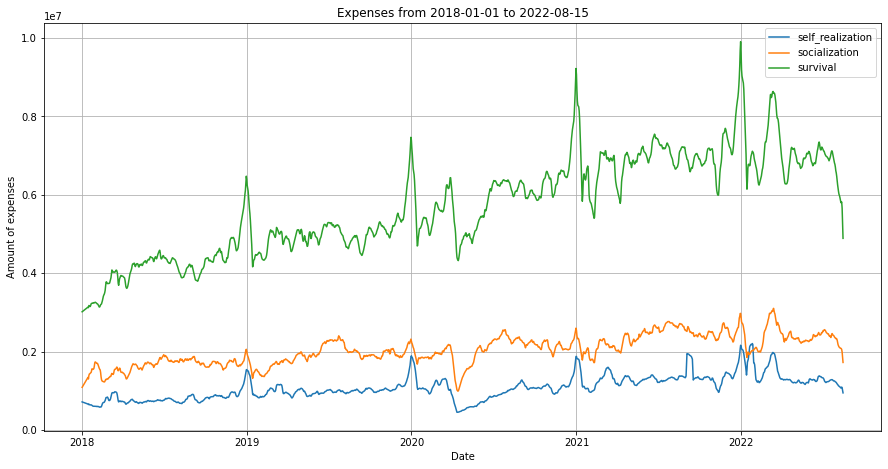

In [6]:
df = data_trend

plt.plot(df)
plt.grid()
plt.xlabel("Date")
plt.ylabel("Amount of expenses")
plt.title(f"Expenses from {df.index[0].date()} to {df.index[-1].date()}")
plt.legend(df.columns);

## Preparing news

In [7]:
try:
    news = pd.read_csv('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv', sep=',', on_bad_lines='skip')
    news.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    news.set_index('Date', inplace=True)
    news.index = news.index.map(datify)
    news = news.iloc[:,2:]
    
    # Cubic spline interpolation for daily values
    old_idx = news.copy().index
    new_idx = pd.date_range(start=data.index.min(),
                            end=data.index.max(),
                            freq='D')
    news = news.reindex(new_idx).interpolate(method='spline', order=3)
    news = news.ewm(span=20).mean()
    news[news<0] = 0.0
except Exception as e:
    print("ERROR", e)
    news = pd.read_csv('../DATA-MINING/SCRAPED-DATA/NEWS-2018-1-1-2022-9-1.csv',
                       sep='\t',
                       on_bad_lines='skip')
    news['title'] = news['title'].apply(preprocess_text)
    print("News are preprocessed.")
    start_d, end_d = datify(min(news['date'])), datify(max(news['date']))
    delta_d = end_d - start_d
    num_days = delta_d.days
    print(f"From {textify(start_d)} to {textify(end_d)}")
    print(f"Number of days: {num_days}")
    num_bins = int(num_days/30)
    print(f"{num_bins} is going to be the number of monthly bins.")
    
    # Topics to visualize (-2 to include all)
    num_of_topics = -2
    # Number of topics after reduction
    reduce_topics_to = 50
    # Start topic
    start_topic = 2

    timestamps = news['date'].to_list()
    titles = news['title'].to_list()
    
    topic_model = BERTopic(embedding_model='distiluse-base-multilingual-cased-v1',
                           verbose=True)
    topics, probs = topic_model.fit_transform(titles)
    topic_model.reduce_topics(titles, nr_topics=reduce_topics_to)
    topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                     topic_prefix=True,
                                                     word_length=10,
                                                     separator="_")
    
    topics_over_time = topic_model.topics_over_time(titles, timestamps, nr_bins=num_bins)
    topic_df = pd.DataFrame(topics_over_time)
    topic_df.rename(columns={"Timestamp": "Date"}, inplace=True)
    topic_df.fillna(0.0, inplace=True)
    
    new_index = pd.date_range(start=textify(start_d),
                              end=textify(end_d + relativedelta(months=-1)),
                              freq='MS')
    
    topic_df = topic_df.pivot(index="Date",
                              columns="Topic",
                              values="Frequency")
    
    topic_df = topic_df.reindex(topic_df.index.union(new_index)).interpolate(method='time')
    topic_df = topic_df.reindex(new_index)
    topic_df.set_axis(topic_labels, axis=1, inplace=True)
    topic_df.fillna(0.0, inplace=True)
    
    topic_df.to_csv('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv', sep=',')
    
    # validate working file
    news = pd.read_csv('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv', sep=',', on_bad_lines='skip')
    news.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    news.set_index('Date', inplace=True)
    news.index = news.index.map(datify)
    news = news.iloc[:,2:]
    
    # Cubic spline interpolation for daily values
    old_idx = news.copy().index
    new_idx = pd.date_range(start=data.index.min(),
                            end=data.index.max(),
                            freq='D')
    news = news.reindex(new_idx).interpolate(method='spline', order=3)
    news = news.ewm(span=20).mean()
    news[news<0] = 0.0

Number of topics: 48


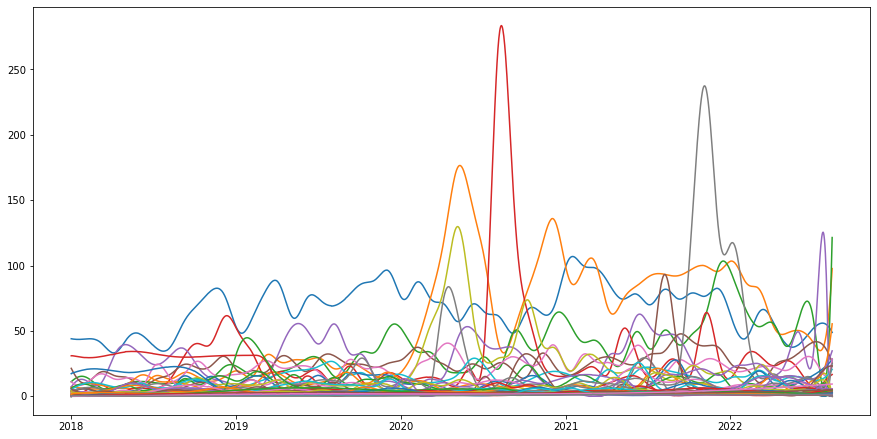

In [8]:
print(f"Number of topics: {len(news.columns)}")
plt.plot(news);
if len(news.columns) <= 35:
    plt.legend(news.columns);

Text(0.5, 1.0, '9 topics left (more than 5 on average and non-stationary)')

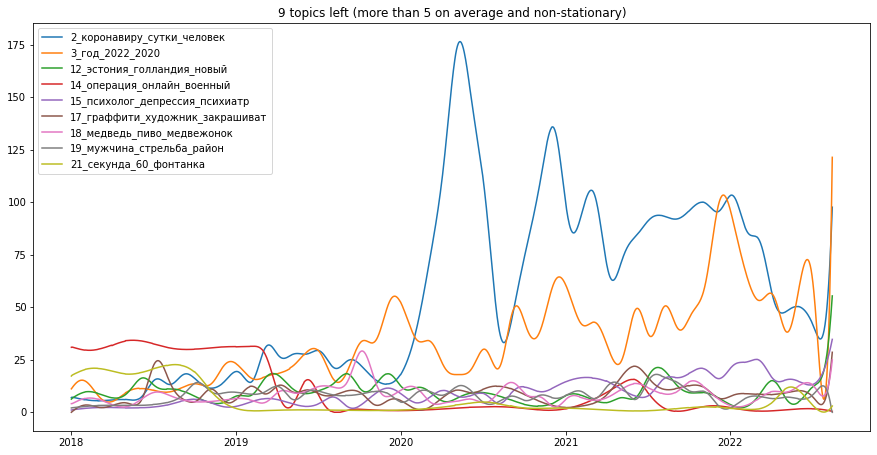

In [9]:
# desired_topics = 20
thr = 5

for col in news.columns:
    result = smt.stattools.adfuller(news[col])
    stat = (result[1] < 0.05) and (result[0] < result[4]['5%'])
    if stat or news[col].mean() < thr:
        news = news.drop(columns=[col])

plt.plot(news);
plt.legend(news.columns);
plt.title(f"{len(news.columns)} topics left (more than {thr} on average and non-stationary)")

In [10]:
news.head()

,2_коронавиру_сутки_человек,3_год_2022_2020,12_эстония_голландия_новый,14_операция_онлайн_военный,15_психолог_депрессия_психиатр,17_граффити_художник_закрашиват,18_медведь_пиво_медвежонок,19_мужчина_стрельба_район,21_секунда_60_фонтанка
2018-01-01,7.000000,11.159091,6.265152,30.946970,1.054475,0.000000,4.106061,2.053030,17.265152
2018-01-02,7.141089,11.463274,6.520120,31.035593,1.143523,0.195244,4.093184,2.118824,17.542015
2018-01-03,7.153427,11.759818,6.695555,31.019123,1.187688,0.375170,4.165194,2.153718,17.700326
2018-01-04,7.133294,12.049047,6.850895,30.976339,1.220861,0.549833,4.258452,2.181123,17.829516
2018-01-05,7.100009,12.330361,6.997817,30.923100,1.249797,0.720940,4.360060,2.205707,17.947352


In [11]:
type(news.index[0])

pandas._libs.tslibs.timestamps.Timestamp

## Model class

In [44]:
class Model:
    # arimax_model = None
    osc_model = None
    trans = None
    news = None
    coeffs_ab = {}
    coeffs_f = None
    coeffs_g = None
    fi = None
    gi = None
    date_start = None
    date_pred = None
    date_end = None
    # start --- pred --- end
    # fitting | prediction
    dsin = None
    dcos = None
    rrmse_dict_arimax = {}
    
    def __init__(self, trans, news, d_start=None, d_pred=None, d_end=None):
        self.trans = trans
        self.news = news
        
        dsin_raw = np.sin(self.trans.index.day.values*2*np.pi / 30)
        dcos_raw = np.cos(self.trans.index.day.values*2*np.pi / 30)
        self.dsin = pd.Series(data=dsin_raw, index=self.trans.index)
        self.dcos = pd.Series(data=dcos_raw, index=self.trans.index)
        
        self.coeffs_f = np.zeros(len(self.news.columns))
        self.coeffs_g = np.zeros(len(self.news.columns))
        
        self.fi = np.zeros(len(self.news.iloc[:,0]))
        self.gi = np.zeros(len(self.news.iloc[:,0]))
        
        # PLACEHOLDER
        self.coeffs_ab = {"a": 0.037, "b": 0.002}
        
        if d_start is None:
            self.date_start = self.trans.index[0]
        else:
            self.date_start = datetime.strptime(d_start, "%Y-%m-%d")
        if d_pred is None:
            half = len(self.trans) // 2
            self.date_pred = self.trans.index[half]
        else:
            self.date_pred = datetime.strptime(d_pred, "%Y-%m-%d")
        
        if d_end is None:
            self.date_end = self.trans.index[-1]
        else:
            self.date_end = datetime.strptime(d_end, "%Y-%m-%d")
        
    def update_dates(self, new_end=None):
        # NOT TESTED ---------------------------------------------------------------------
        self.date_pred = self.date_end
        if new_end is None:
            self.date_end = self.trans.index[-1]
        else:
            self.date_end = datetime.strptime(new_end, "%Y-%m-%d")
        
    def f(self, t, a, b, c):
        # X------------------
        x = np.array(list(self.fi))
        x /= x.max()
        x = x[int(t)]
        # X'-----------------
        dx = np.array(list(self.gi))
        dx /= dx.max()
        dx = dx[int(t)]
        # return [f(t), g(t)]
        return [a*x - b*self.dcos[int(t) - 1], c*dx]
            
    def search(self, model="arimax"):
        if model.lower() == "arimax":
            for topic in self.news.columns:
                _, rrmse = self.train_arimax(exog=self.news[topic])
                self.rrmse_dict_arimax[topic] = rrmse
#                 print(f"{topic} DONE")
        elif model.lower() == "osc":
            coeffs_gi = []
            coeffs_fi = []
            lags_gi = []
            lags_fi = []
            for col in news.columns:
                max_coef = 0
                min_coef = 0
                max_lag = 0
                min_lag = 0
                for lag in range(64):
                    coef = self.news[col].corr(self.trans.shift(lag))
                    if coef > max_coef:
                        max_coef = coef
                        max_lag = lag
                    if coef < min_coef:
                        min_coef = coef
                        min_lag = lag
                coeffs_gi.append(max_coef)
                coeffs_fi.append(min_coef)
                lags_gi.append(max_lag)
                lags_fi.append(min_lag)
            coeffs_gi = np.array(coeffs_gi)
            coeffs_fi = np.array(coeffs_fi)
            coeffs_gi /= coeffs_gi.sum()
            coeffs_fi /= coeffs_fi.sum()
            
            self.coeffs_f = coeffs_fi
            self.coeffs_g = coeffs_gi
            
            fi = np.zeros(len(self.news.iloc[:,0]))
            gi = np.zeros(len(self.news.iloc[:,0]))
            for i in range(len(coeffs_gi)):
                cur_g = np.array(self.news.iloc[:,i])
                cur_f = np.array(self.news.iloc[:,i])
                fi += coeffs_fi[i] * cur_f
                gi += coeffs_gi[i] * cur_g
            self.fi = pd.Series(data=fi, index=self.news.index)
            self.gi = pd.Series(data=gi, index=self.news.index)
    
    def shift_fi_gi(self, lag=-21):
        idx = self.fi.index
        self.fi = pd.Series(data=shift(self.fi, lag, mode='nearest'), index=idx)
        self.gi = pd.Series(data=shift(self.gi, lag, mode='nearest'), index=idx)
    
    def sharpen_fi(self, prom=100, width=10, extra=5):
        idx = self.fi.index
        fn, _, _, _, _ = sharpen(self.fi, prom=prom, width=width, extra=extra)
        self.fi = pd.Series(data=fn, index=idx)
    
    def sharpen_gi(self, prom=100, width=10, extra=5):
        idx = self.gi.index
        gn, _, _, _, _ = sharpen(self.gi, prom=prom, width=width, extra=extra)
        self.gi = pd.Series(data=gn, index=idx)
    
    def select_context_arimax(self, method_name="topn", N=5, M=None):
        if method_name.lower() == "topn":
#             print("topn")
            arr = [
                k for k, v in sorted(
                    self.rrmse_dict_arimax.items(),
                    key=lambda item: item[1]
                )
            ][:N]
        elif method_name.lower() == "topn_underm" and M is not None:
#             print("topn_underm")
            sort_dict = {
                k: v for k, v in sorted(
                    self.rrmse_dict_arimax.items(),
                    key=lambda item: item[1]
                )
            }
            arr = [k for k, v in sort_dict.items() if v <= M]
            if len(arr) < N:
                arr = self.select_context_arimax(method_name="topn", N=N, M=None)
        else:
            print("INVALID SELECTION FUNCTION!")
            arr = []
        return arr
    
    def train_arimax(self, num_days=15, num_topics=5, exog=None):
        rrmse_array = []
        exps = 5
        assert exps < num_days, "num. of experiments greater than num. of days to predict"
#         print(f"END: {self.date_end}")
#         print(f"PRED: {self.date_pred}")
#         print(f"START: {self.date_start}")
        stop_test = self.date_pred + timedelta(num_days)
        assert stop_test < self.date_end, f"{stop_test} greater than {self.date_end}"
        
        if exog is None:
            self.search(model="arimax")
            exog_topics = self.select_context_arimax(method_name="topn", N=5)
            exog = self.news[exog_topics]
        
        for add_exp in reversed(range(exps)):
            start_test = self.date_pred + timedelta(add_exp)

            trans_test = self.trans[
                (self.trans.index >= start_test) & (self.trans.index <= stop_test)
            ].copy()
            trans_train = self.trans[self.trans.index < start_test].copy()
            
            exog_test = exog[
                (exog.index >= start_test) & (exog.index <= stop_test)
            ].copy()
            exog_train = exog[exog.index < start_test].copy()
            
#             print(f"TRANS {len(trans_train)} {len(trans_test)}")
#             print(f"EXOG  {len(exog_train)} {len(exog_test)}")

            arimax = sm.tsa.statespace.SARIMAX(
                trans_train,
                order=(7,1,7),
                seasonal_order=(0,0,0,0),
                exog=exog_train,
                freq='D',
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            
            trans_pred = arimax.predict(start_test, stop_test, exog=exog_test)#[1:]
            assert len(trans_test) == len(trans_pred), "true and pred trans lengths unequal"
            rrmse_cur = mse(trans_test, trans_pred, squared=False)
            rrmse_array.append(rrmse_cur/trans_train.mean())

        rrmse = np.array(rrmse_array).mean()
        
        if exog is None:
            self.date_pred += timedelta(num_days)

        return trans_pred, rrmse
    
    def train_osc_helper(self, args, final=False):
        u = self.trans[
            (self.trans.index >= self.date_start) & (self.trans.index <= self.date_pred)
        ].copy()
        
        x_bias, cos_bias, dx_bias = args[0], args[1], args[2]
        x = [0.0]     # Initial state of X(t)
        dx = [0.0]    # Initial state of dX/dt
        T = np.linspace(0, len(u)-1, len(u))
        h = (T[-1] - T[0]) / len(T)
        a = self.coeffs_ab["a"]
        b = self.coeffs_ab["b"]
        A = np.array([[0., 1.],
                      [-b, -a]])
        f = self.f

        for t in T:
            Y = np.array([[x[-1], dx[-1]]]).T
            k1 = (np.dot(A, Y)        + np.array([f(t,     x_bias, cos_bias, dx_bias)]).T)*h
            k2 = (np.dot(A, (Y+k1/2)) + np.array([f(t+h/2, x_bias, cos_bias, dx_bias)]).T)*h
            k3 = (np.dot(A, (Y+k2/2)) + np.array([f(t+h/2, x_bias, cos_bias, dx_bias)]).T)*h
            k4 = (np.dot(A, (Y+k3))   + np.array([f(t+h,   x_bias, cos_bias, dx_bias)]).T)*h
            Y1 = Y + (k1 + 2*k2 + 2*k3 + k4) / 6
            x.append(Y1[0, 0])
            dx.append(Y1[1, 0])
        x = np.array(x)*b 
        dx = np.array(dx)*b 

        truth = np.array(u.values - u.values[0])
        pred = np.array(x[1:])
        loss = np.linalg.norm(pred - truth) / np.sqrt(len(truth))
        
        print(f"x_bias: {x_bias :.3f} cos_bias: {cos_bias :.3f} dx_bias: {dx_bias :.3f} loss: {loss :.3f}%")
        
        if final:
            return x, T, h
        return loss
    
    def train_osc(self, bounds=None, workers=4):
        if bounds is None:
            bounds = [(-500.0, 500.0), (-200.0, 200.0), (0.0001, 1.0)]
        result = differential_evolution(self.train_osc_helper, bounds, workers=workers)
        
        x_bias, cos_bias, dx_bias = result.x[0], result.x[1], result.x[2]
        x, T, h = self.train_osc_helper([x_bias, cos_bias, dx_bias], final=True)
        return x, T, h

    # TODO train_osc add future prediction
    # TODO train_arimax fix prediction by optimizing on train and predicting test

### Debug only

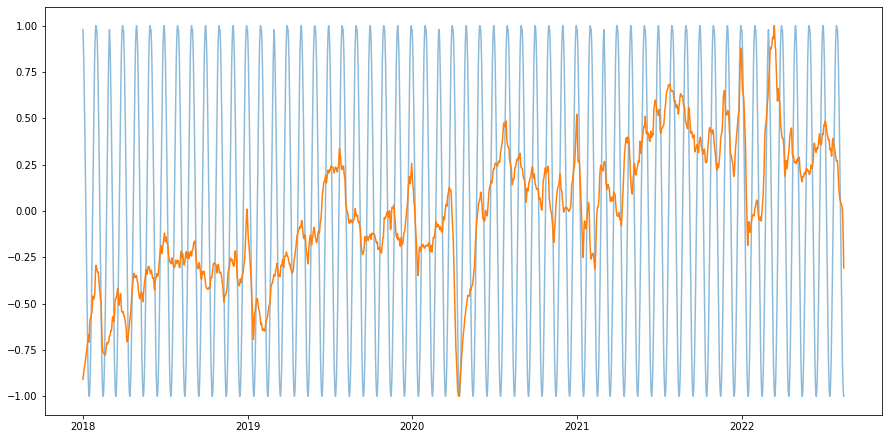

In [45]:
md = Model(data_trend["socialization"], news, d_start=None, d_pred="2019-05-01")

plt.plot(md.dcos, alpha=0.5)
plt.plot(normalize_pandas(md.trans))

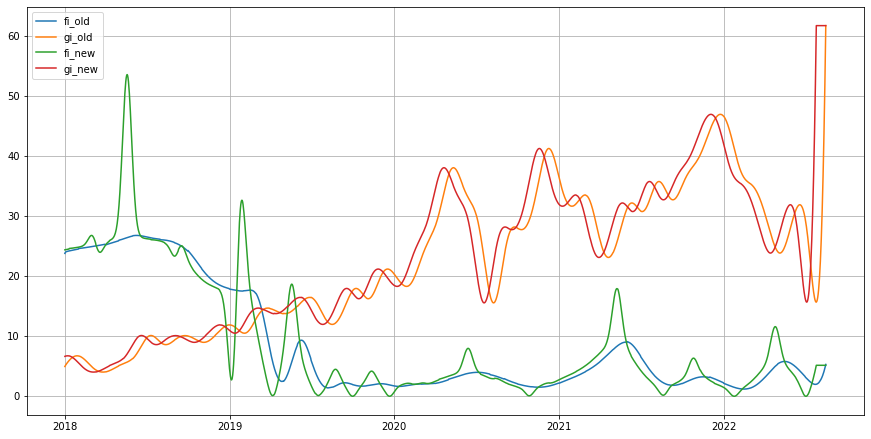

In [46]:
md = Model(data_trend["socialization"], news, d_start=None, d_pred="2019-05-01")
md.search(model="osc")

plt.plot(md.fi, label="fi_old")
plt.plot(md.gi, label="gi_old")

md.sharpen_fi(extra=1)
md.shift_fi_gi()

plt.plot(md.fi, label="fi_new")
plt.plot(md.gi, label="gi_new")

plt.legend()
plt.grid()

In [47]:
md = Model(
    data_trend["socialization"],
    news,
    d_start="2020-03-01",
    d_pred="2020-11-01",
    d_end="2020-12-01"
)
x, T, h = md.train_osc()
plt.plot(x)

# TODO FIX NAN LOSS

x_bias: -416.419 cos_bias: 134.062 dx_bias: 0.911 loss: nan%x_bias: -76.772 cos_bias: 115.531 dx_bias: 0.646 loss: nan%

x_bias: 170.808 cos_bias: 93.399 dx_bias: 0.872 loss: nan%
x_bias: -259.924 cos_bias: -138.481 dx_bias: 0.172 loss: nan%
x_bias: -48.958 cos_bias: -66.300 dx_bias: 0.671 loss: nan%
x_bias: 150.343 cos_bias: -86.081 dx_bias: 0.560 loss: nan%
x_bias: 309.048 cos_bias: -173.200 dx_bias: 0.937 loss: nan%
x_bias: 67.297 cos_bias: 79.623 dx_bias: 0.553 loss: nan%
x_bias: -254.513 cos_bias: -47.900 dx_bias: 0.993 loss: nan%
x_bias: -105.575 cos_bias: -4.011 dx_bias: 0.041 loss: nan%
x_bias: -148.970 cos_bias: 110.747 dx_bias: 0.623 loss: nan%
x_bias: 390.736 cos_bias: 27.410 dx_bias: 0.197 loss: nan%
x_bias: -388.107 cos_bias: -181.745 dx_bias: 0.389 loss: nan%
x_bias: -436.351 cos_bias: -185.029 dx_bias: 0.273 loss: nan%
x_bias: 492.142 cos_bias: 14.802 dx_bias: 0.817 loss: nan%
x_bias: -341.550 cos_bias: -81.626 dx_bias: 0.962 loss: nan%
x_bias: 435.476 cos_bias: 176.335 

Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:


KeyboardInterrupt: 

In [13]:
def ARIMAX_plot(category="socialization", d_pred="2019-05-01", num_days=15):
    date_pred = datetime.strptime(d_pred, "%Y-%m-%d")
    date_end = date_pred + timedelta(num_days)
    
    begin_compute = time.time()
    md = Model(data_trend[category], news, d_start=None, d_pred=d_pred)
    pred, rrmse = md.train_arimax(num_days=num_days)
    delta_compute = time.time() - begin_compute
    
    X = data_trend[category].copy()
    X = X[X.index < date_end]

    plt.grid();
    plt.plot(X, label="Real data");
    plt.plot(pred, label="ARIMAX prediction");
    plt.legend();
    plt.ylabel(f"Expenses on {' '.join(category.split('_'))}");
    plt.xlabel("Date");
    plt.title(f"ARIMAX prediction (5 best, RRMSE {rrmse*100:.2f}%, {int(delta_compute)} s)");

## ARIMAX predictions

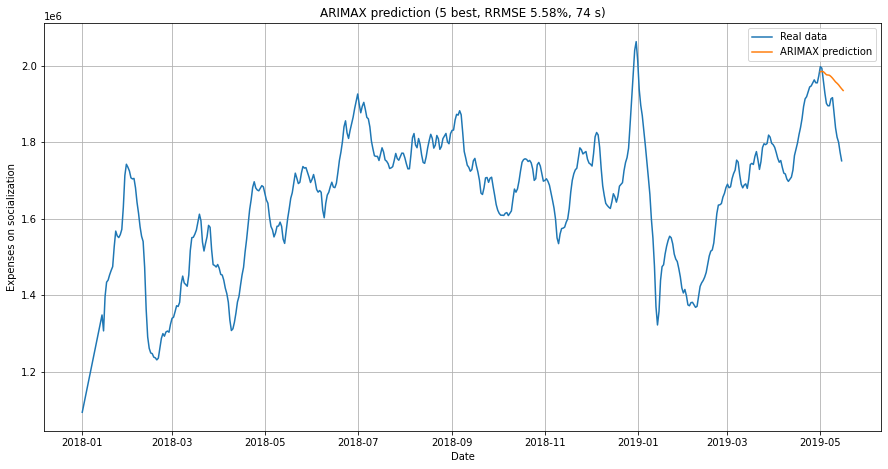

In [14]:
ARIMAX_plot(d_pred="2019-05-01")
#top5 - 5.58%, 66s

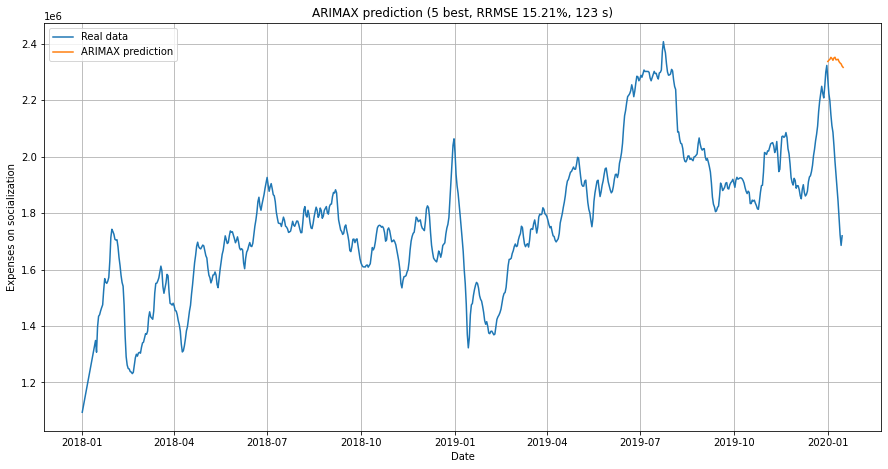

In [15]:
ARIMAX_plot(d_pred="2020-01-01")
#top5 - 15.21%, 117s

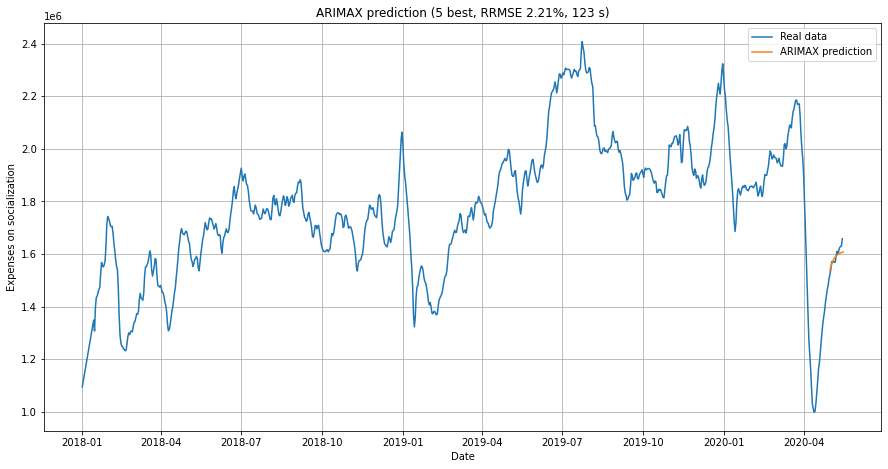

In [16]:
ARIMAX_plot(d_pred="2020-05-01")
#top5 - 2.21%, 122s

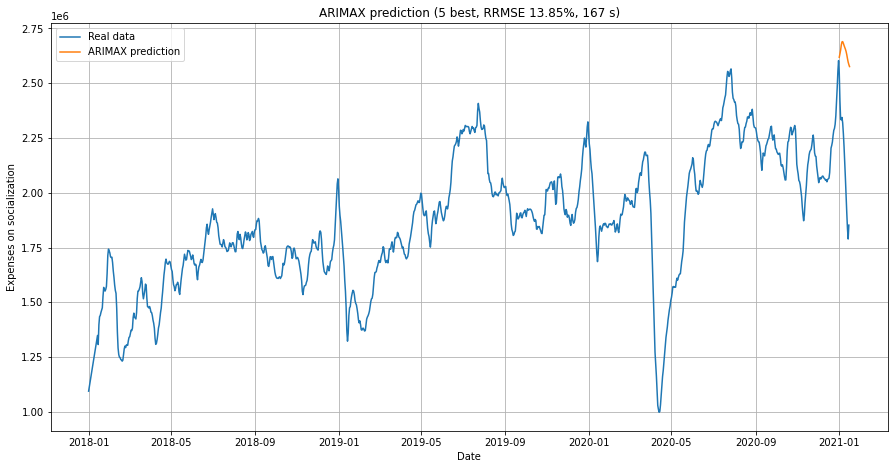

In [17]:
ARIMAX_plot(d_pred="2021-01-01")
#top5 - 13.85%, 157s

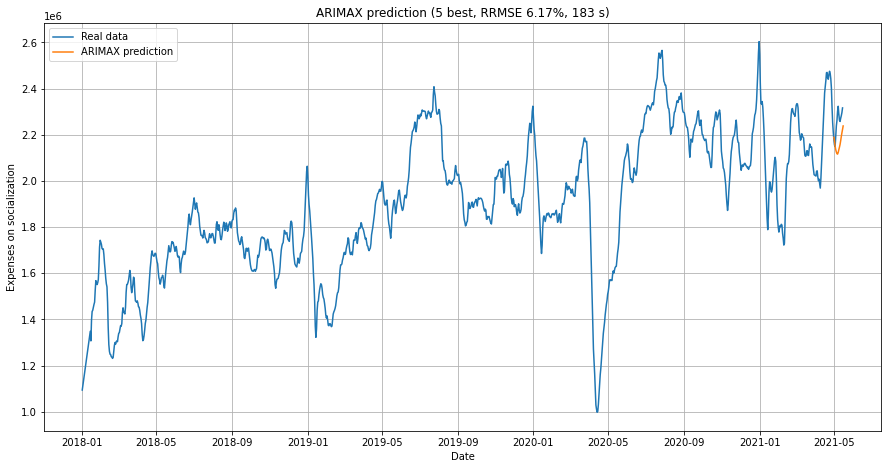

In [18]:
ARIMAX_plot(d_pred="2021-05-01")
#top5 - 6.17%, 167s

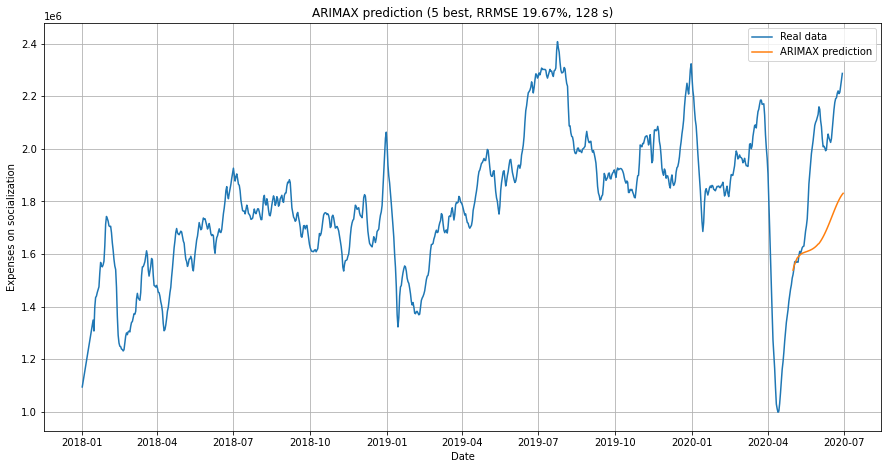

In [19]:
ARIMAX_plot(d_pred="2020-05-01", num_days=60)
#top5 - 19.67%, 118s

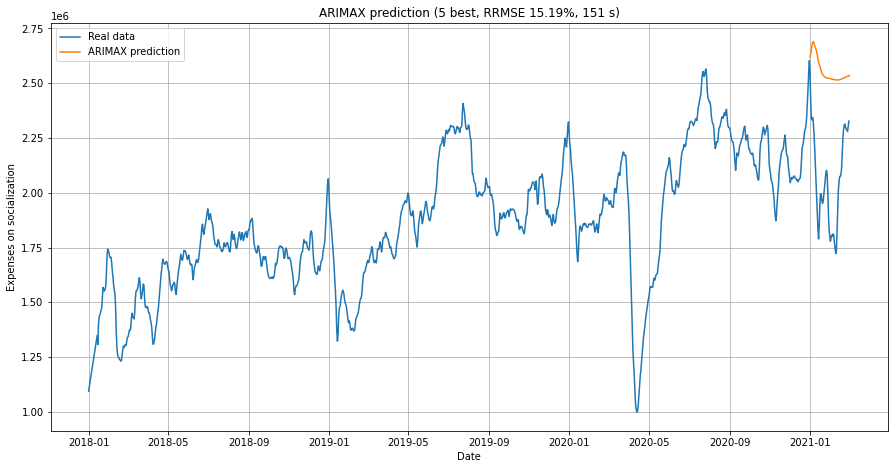

In [20]:
ARIMAX_plot(d_pred="2021-01-01", num_days=60)
#top5 - 15.19%, 160s

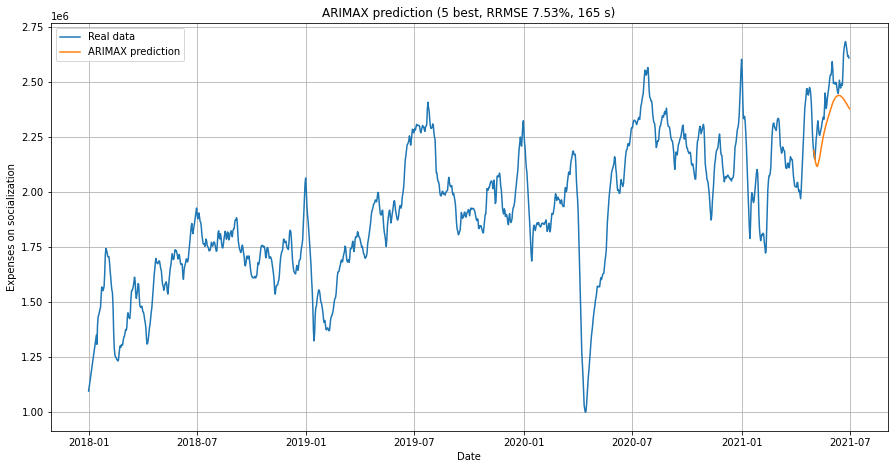

In [21]:
ARIMAX_plot(d_pred="2021-05-01", num_days=60)
#top5 - 7.53%, 168s

Main conclusion: autoregressive models do NOT work well on non-stationary data.

A way to solve this - oscillator model.

## Oscillator predictions